In [1]:
# %% Import Libraries
# Basic libraries
import os                               # directories
import scipy.io                         # load mat files
import numpy as np                      
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
import model_anafunctions as func      # Loading personalized functions


import ruptures as rpt                 # Package for change points

plt.rcParams['font.size'] = 20         # Parameter modified in all the plots of the notebook

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


# Loading Files

This sections in personalized for each researcher. I load the date from the neuronal activity and the behavioural data. 

For the detection of change points you can have a matrix TxN (T=trials, N=Neurons) for instance. 

Text(0.5, 1.0, 'Session for modelling')

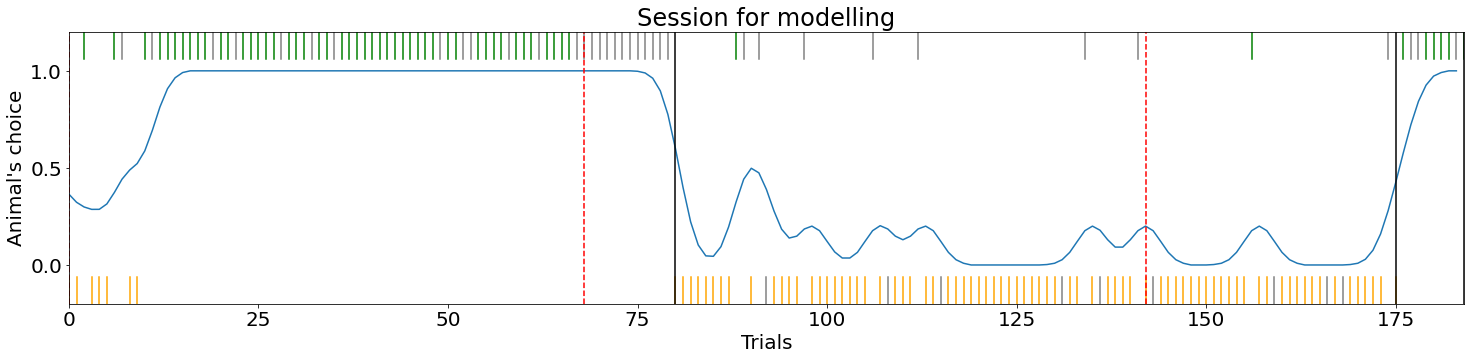

In [2]:
# Loading Data: Full Session
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets' 
ses_n,ses_i = func.load_data(data_path,'FullSession')
full_n,_ = func.concatenate_list(ses_n,0)
full_i,_ = func.concatenate_list(ses_i,0)

# Loading Data: Behaviour
path_beh='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'
ll=0

os.chdir(path_beh)
list_files = os.listdir(path_beh)

for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]
# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]


# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[ll]-1

if np.isnan(DecisionNormalized).any():
    # Find indices of valid values and their corresponding values
    valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
    valid_values = DecisionNormalized[valid_indices]

    # Generate indices to interpolate (including NaNs)
    interpolate_indices = np.arange(len(DecisionNormalized))

    # Interpolate NaN values
    interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
    BD = interpolated_values[0:last_trial]
else:
    BD=DecisionNormalized[0:last_trial]

# Behaviour
# Perform change point detection
algo = rpt.Window(model="l2",width=10).fit(BD)
result_beh = algo.predict(n_bkps=2)


# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(BD)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)    
for i in result_beh:
    plt.axvline(i,color='k')
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,last_trial])
plt.xlabel('Trials')
plt.ylabel("Animal's choice")
plt.title('Session for modelling')

In [3]:
# Preparing data for change points detection version 1:

# Temporal sectors: Period of time selected to compute the mean firing rate
TrialTime_ini = np.where(np.diff(full_i[:,0])==1)[0]-49                         # Initial point: Beginning trial
TrialTime_end = np.append(TrialTime_ini[1:],full_i.shape[0])                    # Final point: Ending trial
# Determining number of trials and number of neurons
num_trials = len(TrialTime_end)
num_neurons = full_n.shape[1]
X_data = np.zeros((num_trials,num_neurons))                                     # Initial matrix of mean firing rate of each neuron (columns), and trials (rows)
for it in range(num_trials):
    X_data[it,:]=np.mean(full_n[TrialTime_ini[it]:TrialTime_end[it],:],0)


MUA = X_data.mean(1)                                                            # Mean value of the firing rate



## Change point detection
PELT method detects the optimal number of change points in the data. 

The basic parameters are: model, min_size, and pen.
model: kernel used to determine the minimum cost function. You have different functions (rbf,l1,l2). In this example rbf detects changes in the mean of the embedded signal.

min_size: minimum number of samples between two change points

pen: penalty for detecting change points. Higher values -> less change points 


Finally, a Dataframe is generated with the different change points of the MUA determining the closest change point of the behaviour.

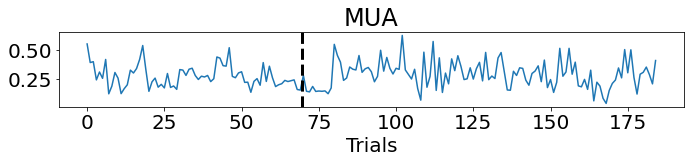

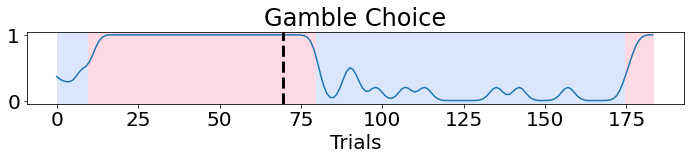

   CP_MUA  CP_behaviour  Trial_distance
0      70            80              10


In [11]:

# Computing number of fixed points:
model_mua = rpt.Pelt(model="rbf", min_size=5)
model_mua.fit(X_data)
result_mua = model_mua.predict(pen=5)

# display
rpt.display(MUA,[],result_mua)
plt.title("MUA")
plt.xlabel("Trials")
plt.show()

# Computing change points from behaviour performance: Gamble Choice probability (BD)
model_ch = rpt.Pelt(model="rbf",min_size=5)
model_ch.fit(BD)
result_ch = model_ch.predict(pen=5)

# display Behavioural and Signal change points
rpt.display(BD,result_ch,result_mua[:-1])
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()

# Change Point distances
cps_mua = result_mua[:-1]
cps_beh = result_ch[:-1]
dist_mua= []
for bkp in cps_mua:
    dist_cp = [np.abs(bkp-i) for i in cps_beh]
    dist_mua.append(np.array(dist_cp))

cp_data = []
cp_behaviour = []
distance = []
for i in range(len(cps_mua)):
    trial_distance = dist_mua[i].min()
    cp_pos = np.argmin(dist_mua[i])
    cp_data.append(cps_mua[i])
    cp_behaviour.append(cps_beh[cp_pos])
    distance.append(trial_distance)

CP_info = {"CP_MUA":cp_data,
           "CP_behaviour":cp_behaviour,
           "Trial_distance":distance}
CP_df = pd.DataFrame(CP_info)
print(CP_df)


## Determining optimal number of change points
We will use two methods to determine the optimal number of change points. One is based on the multi-unit activity data, and the second is based on the relation with the number of behavioural change points computed previously with PELT method.


### 1 - Optimal number of change points depending on behavioural change points:

In the case there is a relation between behavioural and neuronal change points, we should find neuronal change points closer to behavioural change points. However if the behavioural change point is in a different dynamical region, we should have one behavioural change point between two neuronal change points.

Because, the number of neuronal change points are unknown and we cannot assume a direct relation to behavioural change points, I measure the optimal number of neuronal change points that are closer than the behavioural change points

### 2 - Optimal number of change points:

Such as K-mean clustering. We will use the elbow method to determine the optimal number of change points through the value of the cost function.

In this case we compute the change points with "Dynamic Programming" (a precise method). To use the method we need to indicate the number of change points.


(0.0, 11.0)

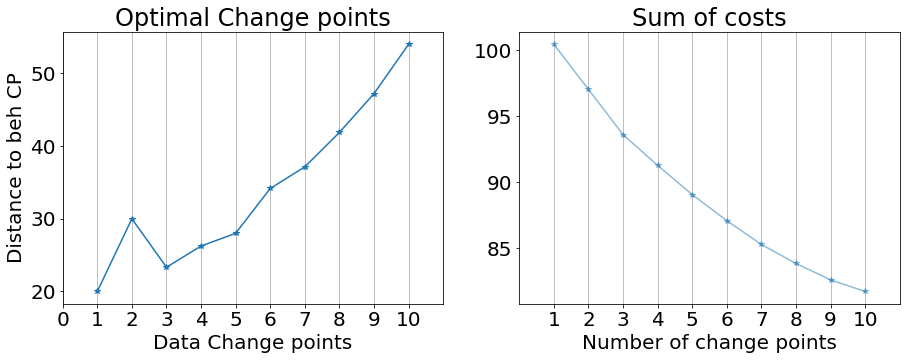

In [6]:
## PARAMETERS TO CHANGE:
min_size_cp = 10                                                                                        # minimum number of samples between two change points
penalty = 5                                                                                             # Value to indicate the influence of the number of behavioural change points
n_bkps_max = 10                                                                                         # Choose the number of changes (elbow heuristic)

#######################################################################################################
######## Computing optimal number of change points through the cost function (elbow mehtod) ###########
#######################################################################################################
algo = rpt.Dynp(model="rbf",min_size=min_size_cp)                                                       # Generating model
algo.fit(X_data)                                                                                        # Fitting Data

# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
pre=algo.predict(n_bkps_max)
array_of_n_bkps = np.arange(1, n_bkps_max + 1)

#Function to return the sum of costs for a specific number of change points (used in Figure section)
def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

######################################################################################################
##### Computing optimal number of change points depending on behavioural change point distance #######
######################################################################################################
algo_b = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_b.fit(X_data)                                                                                      # Fitting Data

# Initialization of variables
cp_data = []                                                                                            # Variable for neuronal change points
cp_behaviour = []                                                                                       # Variable for behavioural change points
distance = []                                                                                           # Variable for trial distance between neuronal and behavioural change points
cp_id =[]                                                                                               # # Variable for the number identification of the neuronal change point determined
                                                                                              
# Loop testing different number of change points
for bk in array_of_n_bkps:
    result_mua_sup = algo_b.predict(n_bkps=bk)
    cps_mua = result_mua_sup[:-1]
    cps_beh = result_ch[:-1]
    dist_mua= []
    for bkp in cps_mua:
        dist_cp = [np.abs(bkp-i) for i in cps_beh]
        dist_mua.append(np.array(dist_cp))

    for i in range(len(cps_mua)):
        trial_distance = dist_mua[i].min()+penalty*(np.abs(len(cps_mua)-len(cps_beh)))
        cp_pos = np.argmin(dist_mua[i])
        cp_data.append(cps_mua[i])
        cp_behaviour.append(cps_beh[cp_pos])
        distance.append(trial_distance)
        cp_id.append(bk)

# Generating DataFrame with change points information
CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)                                                                           # Dataframe

# Grouping values per neuronal change point
CP_opt = CP_df.groupby("CP_id").mean()

######################################################################################################
################## FIGURE: optimal number of change points for both methods ##########################
######################################################################################################
plt.figure(figsize=(15,5))
# Subplot 1: Showing plot of optimal number of neuronal change points 
# taking into acount the number of behavioural change points
plt.subplot(1,2,1)
plt.plot(CP_opt.index,CP_opt["Trial_distance"],'-*')
plt.grid(axis="x")
plt.xlim(1, n_bkps_max + 1)
plt.xticks(range(n_bkps_max + 1))
plt.xlabel("Data Change points")
plt.ylabel("Distance to beh CP")
plt.title("Optimal Change points")
# Subplot 2: Computing and showing the computational cost
plt.subplot(1,2,2)
plt.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
plt.xticks(array_of_n_bkps)
plt.xlabel("Number of change points")
plt.title("Sum of costs")
plt.grid(axis="x")
plt.xlim(0, n_bkps_max + 1)

#### Representation of both measurements for optimal change points in MUA

From the previous plot you can select the optimal number of change points for the neuronal activity. 

The colored regions represents the sections of the behavioural data. The intersection between the colored regions are the bheavioural change points.

Dashed lines represents the neuronal change points.


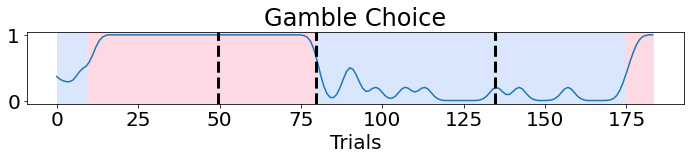

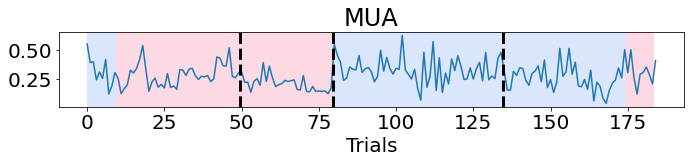

In [9]:
# Decide the optimal change point
opt_bk = 3

algo_ex = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_ex.fit(X_data) 

result_mua_sup = algo_ex.predict(n_bkps=opt_bk)

# Plot of change points for behavioural performance
rpt.display(BD,result_ch,result_mua_sup[:-1])
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()
# Plot of change points for MUA
rpt.display(MUA,result_ch,result_mua_sup[:-1])
plt.title("MUA")
plt.xlabel("Trials")
plt.show()

### Comparison between neuronal and behavioural change 

The next plot shows the relation and if the neuronal change points follows the behavioural change points

   CP_data  CP_behaviour  Trial_distance  CP_id
0       50            80              30      1
1       80            80               0      2
2      135           175              40      3


Text(0, 0.5, 'Neuronal Change Point')

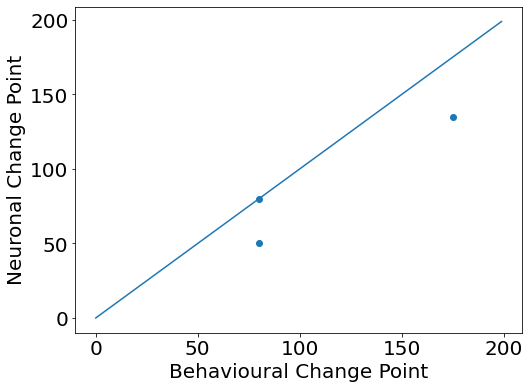

In [10]:
k_bkpt = 0
cp_data = []
distance = []
cp_behaviour = []
cp_id = []
for bkp in result_mua_sup[:-1]:
        dist_cp = [np.abs(bkp-i) for i in result_ch[:-1]]
        dist_mua = np.array(dist_cp)

        trial_distance = dist_mua.min()
        cp_pos = np.argmin(dist_mua)
        cp_data.append(bkp)
        cp_behaviour.append(result_ch[cp_pos])
        distance.append(trial_distance)
        k_bkpt +=1
        cp_id.append(k_bkpt)

CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)
print(CP_df)

plt.figure(figsize=(8,6))
plt.scatter(CP_df["CP_behaviour"],CP_df["CP_data"])
plt.plot(range(200),range(200))
plt.xlabel("Behavioural Change Point")
plt.ylabel("Neuronal Change Point")